In [ ]:
# fetch the chairs dataset
%mkdir -p content/rendered_chairs
!wget https://www.di.ens.fr/willow/research/seeing3Dchairs/data/rendered_chairs.tar
!tar -xvf  'rendered_chairs.tar' -C 'content/rendered_chairs'

sample_data


In [6]:
# fetch the beta-vae synthetic dataset (from the deepmind repo)
!git clone https://github.com/deepmind/dsprites-dataset
!rm -rf .git* *.md LICENSE *.ipynb *.gif *.hdf5

Cloning into 'dsprites-dataset'...
remote: Enumerating objects: 16, done.
remote: Total 16 (delta 0), reused 0 (delta 0), pack-reused 16
Unpacking objects: 100% (16/16), done.


In [7]:
import torch 
import torch.nn as nn
from torchvision import datasets, transforms, utils
from torch.nn import functional as F

import numpy as np
import matplotlib.pyplot as plt
import random

In [8]:
## GPU
device = torch.device('cuda:' + str(0) if torch.cuda.is_available() else 'cpu')

SEED = 1

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

## Simple MNIST For Testing

In [ ]:
BATCH_SIZE = 100

In [ ]:
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)


Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
val_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=True)

## VAE Model

In [21]:
class VAE(nn.Module):
    def __init__(self, inp_dim, latent_dim, h_dim):
        super(VAE, self).__init__()

        #inp_dim is flattened image size
        self.inp_dim = inp_dim
        self.latent_dim = latent_dim
        self.h_dim = h_dim

        #### ENCODER ##########
        #3 hidden layer encoder
        self.e_fc1 = nn.Linear(inp_dim, h_dim)
        self.e_fc2 =  nn.Linear(h_dim, int(h_dim/2))
        
        self.e_fc_mean = nn.Linear(int(h_dim/2), latent_dim)
        self.e_fc_log_std = nn.Linear(int(h_dim/2), latent_dim)

        #### DECODER ##########
        # 3 hidden layer decoder
        self.d_fc1 = nn.Linear(latent_dim, int(h_dim/2))
        self.d_fc2 = nn.Linear(int(h_dim/2), h_dim)
        self.d_fc3 = nn.Linear(h_dim, inp_dim)
        
    
    def forward(self, x):
        mean, log_std = self.encode(x)
        z = self.sample(mean, log_std)
        x_hat = self.decode(z)

        return x_hat, mean, log_std

    #given an x from the dataset, finds mean and log_var
    #for the variational distribution q(z)
    def encode(self, x):
        w = F.relu(self.e_fc1(x.view(-1, self.inp_dim)))
        w = F.relu(self.e_fc2(w))
        mean = self.e_fc_mean(w)
        log_std = self.e_fc_log_std(w)

        #batch of mean and log_var for q(z | x)
        return mean, log_std

    def decode(self, z):
        w = F.relu(self.d_fc1(z))
        w = F.relu(self.d_fc2(w))
        
        #image approximation, with pixel values in [0,1]
        #assumed bernoulli distribution over each pixel, and the pixel value
        # is prob(pixel is on)
        x_hat = F.sigmoid(self.d_fc3(w)) 

        return x_hat
    
    #sample using reparameterization trick
    def sample(self, mean, log_std):
        #sample from N(0,I) and use 
        #reparameterization trick to transform
        #to given mean and variance
        std = torch.exp(log_std)

        sample_z = mean + std*torch.randn_like(mean)

        return sample_z

    #if train, samples highest probability values
    def sample_ims(self, num_ims, mean, log_std, train = True):
        if train:
            z = self.sample(mean, log_std)
        else:
            z = mean

        ims = self.decode(z)
        return ims

        
    #sample from the 
    def sample_ims_from_prior(self, num_ims, train=True, im_size = (28,28)):
        #mean = 0, std = I
        mean = torch.zeros((num_ims, self.latent_dim))
        log_std = torch.zeros((num_ims, self.latent_dim))

        ims_from_prior = self.sample_ims(num_ims, mean, log_std, train)
        ims = ims_from_prior.view((-1,im_size[0],im_size[1]))

        return ims

    def sample_ims_like(self, x, num_ims, train=True, im_size = (28,28)):
        #mean = 0, std = I
        mean, log_std = self.encode(x)
        ims_from_prior = self.sample_ims(num_ims, mean, log_std, train)
        ims = ims_from_prior.view((-1,im_size[0],im_size[1]))

        return ims

def sample_ims_like(vae_model, x, num_ims, train=True, im_size = (28,28)):

    mean, log_std = vae_model.encode(x)

    mean = mean.repeat(num_ims,1)
    log_std = log_std.repeat(num_ims, 1)

    ims = vae_model.sample_ims(num_ims, mean, log_std, train)
    ims = ims.view((-1,im_size[0], im_size[1]))

    return ims

## VAE Training

In [16]:
config = {
    "epoch": 10,
    "lr": 1e-3,
    "batch": 100
}

In [17]:
# negative ELBO loss
# = reconstruction_loss + KL(q || z_prior) 
def vae_loss_func(x_hat, x, mean, log_std, batch_size):
    recon_loss = F.binary_cross_entropy(x_hat, x)

    # - D_{KL} = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # note the negative D_{KL} in appendix B of the paper
    KLD = -0.5 * torch.sum(1 + 2*log_std - mean**2 - torch.exp(log_std)**2)
    # Normalise by same number of elements as in reconstruction
    KLD /= (batch_size * 784)

    loss = recon_loss+ KLD

    return loss

def vae_val_loss(vae_model, val_loader, batch_size):
    val_loss = 0.0
    batch_size = 0

    for x_batch, labels in val_loader:
    
        x_hat_batch, mean_batch, log_std_batch = vae_model(x_batch)

        loss_value = vae_loss_func(x_hat_batch, x_batch.view(-1, vae_model.inp_dim), mean_batch, log_std_batch, batch_size)

        batch_size += 1
        val_loss += loss_value

    val_loss = val_loss/batch_size

    return val_loss

#config = dict of 'epoch', 'lr', 'batch', ''
def vae_train(vae_model, config, train_dataset, val_dataset):
    vae_model = vae_model.to(device)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=config["batch"], shuffle=True)
    val_loader = torch.utils.data.DataLoader(dataset = val_dataset, batch_size = config["batch"], shuffle =False)

    optimizer = torch.optim.Adam(vae_model.parameters(), lr = config["lr"])

    num_epochs = config["epoch"]

    epoch_loss = torch.zeros(num_epochs)
    val_epoch_loss = torch.zeros(num_epochs)

    for epoch in range(num_epochs):

        epoch_loss[epoch] = 0.0
        batch_size = 0

        for x_batch, labels in train_loader:
            
            x_hat_batch, mean_batch, log_std_batch = vae_model(x_batch)

            loss_val = vae_loss_func(x_hat_batch, x_batch.view(-1, vae_model.inp_dim), mean_batch, log_std_batch, config["batch"])

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            batch_size += 1
            epoch_loss[epoch] += loss_val

        epoch_loss[epoch] = epoch_loss[epoch]/batch_size

        #compute val_loss
        val_epoch_loss[epoch] = vae_val_loss(vae_model, val_loader, config["batch"])
        
        print("Epoch {}/{} -- Train loss: {}, Val loss: {}".format(epoch+1, num_epochs, epoch_loss[epoch], val_epoch_loss[epoch]))
    
    plt.plot(epoch_loss.to('cpu').detach().numpy(), label = "Train Loss (-ELBO)")
    plt.plot(val_epoch_loss.to('cpu').detach().numpy(), label="Validation Loss (-ELBO)")
    plt.title("VAE Loss over Epochs") 
    plt.xlabel("Epoch")
    plt.ylabel("Negative ELBO Loss")

In [ ]:
vae_m = VAE(inp_dim = 784, latent_dim =20, h_dim=300)


In [ ]:
sampled_ims_pre = vae_m.sample_ims_from_prior(num_ims=5)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
sampled_ims_pre = sampled_ims_pre.to('cpu').detach().numpy()

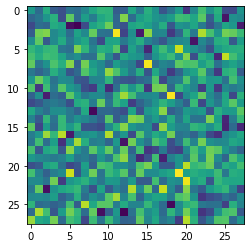

In [ ]:
plt.imshow(sampled_ims_pre[0,:])

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 1/10 -- Train loss: 0.23286844789981842, Val loss: inf
Epoch 2/10 -- Train loss: 0.16982825100421906, Val loss: inf
Epoch 3/10 -- Train loss: 0.15508078038692474, Val loss: inf
Epoch 4/10 -- Train loss: 0.1491347849369049, Val loss: inf
Epoch 5/10 -- Train loss: 0.1456436961889267, Val loss: inf
Epoch 6/10 -- Train loss: 0.14330805838108063, Val loss: inf
Epoch 7/10 -- Train loss: 0.14175096154212952, Val loss: inf
Epoch 8/10 -- Train loss: 0.14036870002746582, Val loss: inf
Epoch 9/10 -- Train loss: 0.13929389417171478, Val loss: inf
Epoch 10/10 -- Train loss: 0.13842403888702393, Val loss: inf


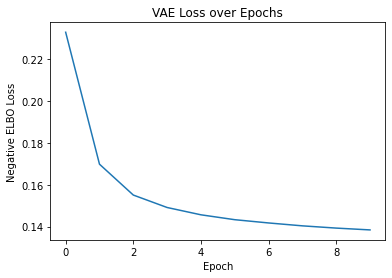

In [ ]:
vae_train(vae_m, config, train_dataset, val_dataset)


In [ ]:
sampled_ims_post = vae_m.sample_ims_from_prior(num_ims=5, train=True)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
sampled_ims_post = sampled_ims_post.to('cpu').detach().numpy()

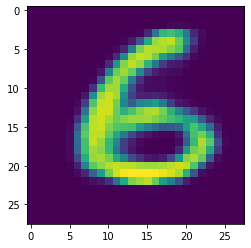

In [ ]:
plt.imshow(sampled_ims_post[1,:])

In [ ]:
for i in train_loader:
    x_batch = i
    break

In [ ]:
x_data, labels=  x_batch

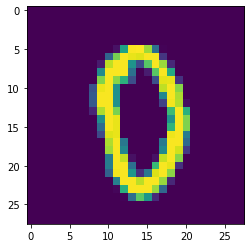

In [ ]:
data_im = x_data[3,0]
plt.imshow(data_im)

torch.Size([1, 28, 28])

In [ ]:
samples_like = sample_ims_like(vae_m, torch.tensor(data_im).view(-1, 784), num_ims=5, train=True, im_size = (28,28))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
samples_like = samples_like.to('cpu').detach().numpy()

In [ ]:
samples_like.shape

(5, 28, 28)

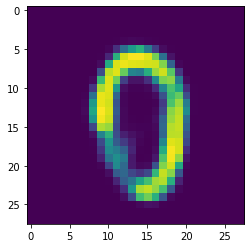

In [ ]:
plt.imshow(samples_like[3,:])

## Disentanglement Metric (from B-VAE)

In [9]:
# citation: the below code for visualizing dsprites dataset is from : 
# https://github.com/deepmind/dsprites-dataset/blob/master/dsprites_reloading_example.ipynb
%cd dsprites-dataset
dataset_zip = np.load('dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz', allow_pickle=True, encoding='bytes')
imgs = dataset_zip['imgs']
latents_values = dataset_zip['latents_values']
latents_classes = dataset_zip['latents_classes']
metadata = dataset_zip['metadata'][()]
position_labels = latents_values[0:32, -1]
orientation_labels = list(set(latents_values[:, -3]))

/content/dsprites-dataset


In [10]:
# x = np.where(latents_classes[:, -1] == 1)
# print(f"latent values: {x[0]}")
# print(f"latent classes: {np.take(latents_values, x[0], axis=0)}")
# print(list(set(latents_values[:, -4])))
print(position_labels)

[0.         0.03225806 0.06451613 0.09677419 0.12903226 0.16129032
 0.19354839 0.22580645 0.25806452 0.29032258 0.32258065 0.35483871
 0.38709677 0.41935484 0.4516129  0.48387097 0.51612903 0.5483871
 0.58064516 0.61290323 0.64516129 0.67741935 0.70967742 0.74193548
 0.77419355 0.80645161 0.83870968 0.87096774 0.90322581 0.93548387
 0.96774194 1.        ]


In [11]:
# citation: the below code for visualizing dsprites dataset is from : 
# https://github.com/deepmind/dsprites-dataset/blob/master/dsprites_reloading_example.ipynb

latents_sizes = metadata[b'latents_sizes']
latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:],
                                np.array([1,])))

def latent_to_index(latents):
  return np.dot(latents, latents_bases).astype(int)


def sample_latent(size=1):
  samples = np.zeros((size, latents_sizes.size))
  for lat_i, lat_size in enumerate(latents_sizes):
    samples[:, lat_i] = np.random.randint(lat_size, size=size)

  return samples

def show_images_grid(imgs_, num_images=25):
  ncols = int(np.ceil(num_images**0.5))
  nrows = int(np.ceil(num_images / ncols))
  _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
  axes = axes.flatten()

  for ax_i, ax in enumerate(axes):
    if ax_i < num_images:
      ax.imshow(imgs_[ax_i], cmap='Greys_r',  interpolation='nearest')
      ax.set_xticks([])
      ax.set_yticks([])
    else:
      ax.axis('off')

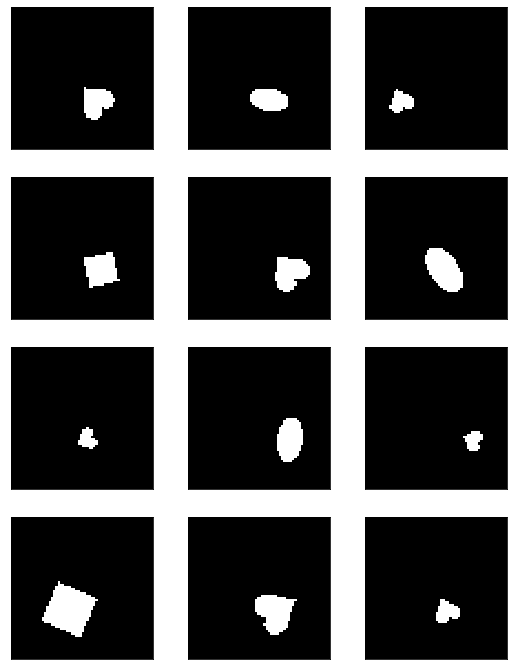

In [43]:
# fixed_factor is the index of the factor we want to keep fixed 
# (i.e. if we want the POS Y fixed we pass in 1)
def sample_dsprites(fixed_factor, batch_size):
    length = 0
    while (length < batch_size):
        fixed_factor = -1 * fixed_factor
        fixed_value = 0
        if (fixed_factor == -1 or fixed_factor == -2):
            fixed_value = random.choice(position_labels)
        elif (fixed_factor == -3):
            fixed_value = random.choice(orientation_labels)
        elif (fixed_factor == -4):
            fixed_value = round(random.uniform(0.5,1), 1)

        # fixed_indices = latents_values[:, fixed_factor] == fixed_value
        # return latents_values[fixed_indices]
        fixed_indices = np.where(latents_values[:, fixed_factor] == fixed_value)
        fixed_imgs = list(imgs[fixed_indices])
        length = np.shape(fixed_imgs)[0]

    return random.sample(fixed_imgs, batch_size)

# Samples where the scale is the same
x = sample_dsprites(1, 5000)
show_images_grid(x, 12)

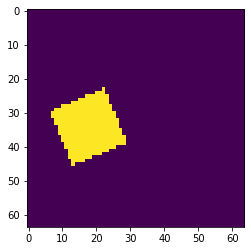

In [183]:
plt.imshow(x[4])

In [13]:
class LinClassifier(nn.Module):
    def __init__(self, in_dims, out_dims, layer=nn.Linear):
        super(LinClassifier, self).__init__()
        
        self.net = nn.Sequential(
                layer(in_dims, out_dims)
            )

    #outputs probability logits
    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.net(x)
        out = out.squeeze()
    
        return out

In [36]:
#different method for getting latent z from image x for diff models
#model type = "VAE" or "GAN"
def get_z_from_x(x, model, model_type="VAE"):
    if model_type == "VAE":
        m, log_std= model.encode(x)
        z = model.sample(m, log_std)
        return z

    elif model_type == "GAN":
        return invert_gan_sample(x, model)
    else:
        print("Incorrectly specified model_type, must be 'VAE' or 'GAN'.")
        return None

#for a gan model, find a latent z producing an x similar to one
#provided
#x is a batch of images
def invert_gan_sample(x, generator, num_iter = 100, lr = 1e-3):
    #initialize z from prior p(z) = N(0, I)
    z = torch.randn((x.size(0), generator.latent_dim), requires_grad=True)

    optimizer = torch.optim.Adam([z], lr)

    for iter in range(num_iter):
        optimizer.zero_grad()

        #MSE loss for reconstruction
        recon_loss = ((x - generator(z))**2).sum()

        recon_loss.backward()
        optimizer.step()

        print("GAN inversion loss: {}, iteration : {}/{}".format(recon_loss, iter, num_iter))

    return z


In [15]:
classifier_config = {
    "epoch": 10,
    "lr": 1e-3,
    "batch": 100
}

In [45]:
def get_classifier_batch(batch_size, sub_batch_size, model, model_type):
    #batch size is the "upper" batch size 
    #we have batch_size number of unique labels
    #each has a "sub_batch_size" number of images
    labels = np.random.randint(0,4, size=batch_size)
    classifier_inp_batch = torch.zeros((batch_size, model.latent_dim))
    for i in range(batch_size):
        sub_batch_x = sample_dsprites(labels[i], 2*sub_batch_size)

        sub_batch_x = torch.Tensor(sub_batch_x).to(device).float().view((-1, 1, 64, 64))
        
        #get z for subbatch
        sub_batch_z = get_z_from_x(sub_batch_x, model.to(device), model_type)
        
        #we use z_avg as the input to classifier
        z_avg = (sub_batch_z[:sub_batch_size] - sub_batch_z[sub_batch_size:]).mean(dim=0)

        classifier_inp_batch[i,:] = z_avg

    return classifier_inp_batch, torch.Tensor(labels)

In [46]:
def classifier_val_acc(num_val_epochs, num_batches_per_val_epoch, model,model_type):
    for epoch in range(num_val_epochs):
        val_acc = 0.0
        batch_size = 0

        for i in range(num_batches_per_val_epoch):
            classifier_inp_batch, labels = get_classifier_batch(32, 
                                                        sub_batch_size=16, 
                                                        model=model,
                                                        model_type =model_type)
            pred_logits = lin_classifier(classifier_inp_batch)
            pred_labels = torch.argmax(pred_logits, dim=1)

            num_correct = (pred_labels == labels).sum()
            acc = num_correct/32

            val_acc += acc.item()
            batch_size += 1

        return val_acc/batch_size

def train_lin_classifier(config, lin_classifier, model, model_type):
    c_optimizer = torch.optim.Adam(lin_classifier.parameters(), config["lr"])

    lin_classifier = lin_classifier.to(device)
    model = model.to(device)

    num_epochs = config["epoch"]

    epoch_loss = torch.zeros(num_epochs)
    val_acc = torch.zeros(num_epochs)

    num_train_batches_per_epoch = 200

    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(num_epochs):

        epoch_loss[epoch] = 0.0
        batch_size = 0

        for i in range(num_train_batches_per_epoch):
            classifier_inp_batch, labels = get_classifier_batch(config["batch"], 
                                                        sub_batch_size=16, 
                                                        model=model,
                                                        model_type =model_type)
            pred_logits = lin_classifier(classifier_inp_batch)

            loss_val = criterion(pred_logits, label)

            c_optimizer.zero_grad()
            loss_val.backward()
            c_optimizer.step()

            batch_size += 1
            epoch_loss[epoch] += loss_val.item()

        epoch_loss[epoch] = epoch_loss[epoch]/batch_size

        #compute val_loss
        val_acc[epoch] =classifier_val_acc(50,num_batches_per_val_epoch=200,
                                           model= model,
                                           model_type=model_type)
        
        print("Epoch {}/{} -- Train loss: {}, Val Acc: {}".format(epoch+1, num_epochs, epoch_loss[epoch], val_acc[epoch]))
    
    return val_acc
    

In [48]:
def disentangle_metric(model, model_type):
    lin_classifier = LinClassifier(in_dims=model.latent_dim, out_dims=4)

    classifier_config = {
        "epoch": 1,
        "lr": 1e-3,
        "batch": 32
    }

    #train classifier
    train_lin_classifier(classifier_config, lin_classifier, model, model_type)
    
    #report final val accuract as metric, on each type of factor
    return val_acc[-1]

In [19]:
#linear classifier for dsprites data set must predict from one of 4 factors
LATENT_DIMS = 10
factor_classifier = LinClassifier(in_dims= LATENT_DIMS, out_dims=4)


In [21]:
vae_model = VAEConv(latent_dim =10, n_channels=1)

In [22]:
vae_model.load_state_dict(torch.load("/content/VAE_dsprites_weights"))

<All keys matched successfully>

In [49]:
disentangle_metric(model=vae_model, model_type="VAE")

KeyboardInterrupt: ignored

In [51]:
samples = sample_dsprites(fixed_factor=2, batch_size=32)

In [52]:
np.shape(samples)

(32, 64, 64)

## VAE Conv Model

In [20]:
class VAEConv(nn.Module):
    #architecture follows that of the B-VAE paper
    def __init__(self, latent_dim, im_size=(64,64), n_channels=3):
        super(VAEConv, self).__init__()

        #inp_dim is flattened image size
        self.latent_dim = latent_dim
        self.im_size = im_size
        self.n_channels = n_channels

        #### ENCODER ##########
        #Convolution based encoder
        #NOTE im_size must be (64, 64) to work (or a multiple of 64,64)
        self.e_conv1 = nn.Conv2d(in_channels = n_channels,
                                out_channels = 32,
                                 kernel_size =4,
                                 stride=2,
                                 padding=1)
        self.e_conv2 =  nn.Conv2d(in_channels = 32,
                                out_channels = 32,
                                 kernel_size =4,
                                 stride=2,
                                 padding=1)
        self.e_conv3=  nn.Conv2d(in_channels = 32,
                                out_channels = 64,
                                 kernel_size =4,
                                 stride=2,
                                 padding=1)
        self.e_conv4 = nn.Conv2d(in_channels = 64,
                                out_channels = 64,
                                 kernel_size =4,
                                 stride=2,
                                 padding=1)
        #output of this block will be scalar Bx256x(1x1)
        #for input size 64 x 64 - we use fc layer on it next
        self.e_conv5 = nn.Conv2d(in_channels = 64,
                                out_channels = 256,
                                 kernel_size =4,
                                 stride=1)
        #reshape to (B x 256)
        #takes output of convolution
        self.e_fc_mean = nn.Linear(256, latent_dim)
        self.e_fc_log_std = nn.Linear(256, latent_dim)

        #### DECODER ##########
        # Convolutional decoder
        #takes a latent sample z and generates image
        self.d_fc1 = nn.Linear(latent_dim, 256)

        #must reshape to (Bx 1 x 1) next for conv layers
        self.d_conv1 = nn.ConvTranspose2d(in_channels=256,
                                          out_channels=64,
                                          kernel_size=4
                                          )
        self.d_conv2 = nn.ConvTranspose2d(in_channels=64,
                                          out_channels=64,
                                          kernel_size=4,
                                          stride=2, 
                                          padding=1)
        self.d_conv3 = nn.ConvTranspose2d(in_channels=64,
                                    out_channels=32,
                                    kernel_size=4,
                                    stride=2, 
                                    padding=1)
        self.d_conv4 = nn.ConvTranspose2d(in_channels=32,
                            out_channels=32,
                            kernel_size=4,
                            stride=2, 
                            padding=1)
        self.d_conv5 = nn.ConvTranspose2d(in_channels=32,
                    out_channels=n_channels,
                    kernel_size=4,
                    stride=2, 
                    padding=1)
        
    
    def forward(self, x):
        #x inputs expected to be C x H xW
        mean, log_std = self.encode(x)
        z = self.sample(mean, log_std)
        x_hat = self.decode(z)

        return x_hat, mean, log_std

    #given an x from the dataset, finds mean and log_var
    #for the variational distribution q(z)
    def encode(self, x):
        w = F.relu(self.e_conv1(x))
        w = F.relu(self.e_conv2(w))
        w = F.relu(self.e_conv3(w))
        w = F.relu(self.e_conv4(w))
        w = F.relu(self.e_conv5(w))
        
        w = w.view((-1,  256))
        mean = self.e_fc_mean(w)
        log_std = self.e_fc_log_std(w)

        #batch of mean and log_var for q(z | x)
        return mean, log_std

    def decode(self, z):
        w = F.relu(self.d_fc1(z))
        w = w.view((-1, 256, 1, 1))
        w = F.relu(self.d_conv1(w))
        w = F.relu(self.d_conv2(w))
        w = F.relu(self.d_conv3(w))
        w = F.relu(self.d_conv4(w))
        w = self.d_conv5(w)

        #image approximation, with pixel values in [0,1]
        #assumed bernoulli distribution over each pixel, and the pixel value
        # is prob(pixel is on)
        #x_hat = F.sigmoid(self.d_fc3(w)) 
        x_hat = w

        #note: im has channel C X H x W
        return x_hat
    
    #sample using reparameterization trick
    def sample(self, mean, log_std):
        #sample from N(0,I) and use 
        #reparameterization trick to transform
        #to given mean and variance
        std = torch.exp(log_std)

        sample_z = mean + std*torch.randn_like(mean)

        return sample_z

    #if train, samples highest probability values
    def sample_ims(self, num_ims, mean, log_std, train = True):
        if train:
            z = self.sample(mean, log_std)
        else:
            z = mean

        ims = self.decode(z)
        ims = F.sigmoid(ims)
        #print(ims.size())
        return ims.permute(0, 2,3,1)

        
    #sample from the 
    def sample_ims_from_prior(self, num_ims, train=True):
        #mean = 0, std = I
        mean = torch.zeros((num_ims, self.latent_dim))
        log_std = torch.zeros((num_ims, self.latent_dim))

        ims_from_prior = self.sample_ims(num_ims, mean, log_std, train)
        #ims = ims_from_prior.view((-1,self.im_size[0],self.im_size[1]))

        return ims_from_prior

    def sample_ims_like(self, x, num_ims, train=True):
        mean, log_std = self.encode(x)

        mean = mean.repeat(num_ims,1)
        log_std = log_std.repeat(num_ims, 1)

        ims = self.sample_ims(num_ims, mean, log_std, train)
        #ims = ims.view((-1,im_size[0], im_size[1]))

        #place channel at end
        return ims

## VAE Dsprites Train

In [ ]:
np.shape(imgs)

(737280, 64, 64)

In [8]:
np.random.shuffle(imgs)

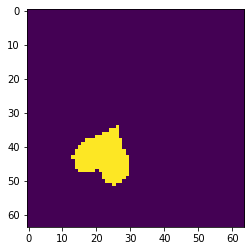

In [11]:
plt.imshow(imgs[3,:,:])

In [141]:
# negative ELBO loss
# = reconstruction_loss + KL(q || z_prior) 
#some code from https://github.com/1Konny/Beta-VAE/blob/master/solver.py
def vae_conv_loss_func(x_hat, x, mean, log_std, batch_size, decoder_type="B"):
    if decoder_type=="B":
        #bernoulli type output distribution assumed
        recon_loss = F.binary_cross_entropy_with_logits(x_hat, x, size_average=False).div(batch_size)
    #for Gaussian type output, do MSE 
    else:
        x_hat = F.sigmoid(x_hat)
        recon_loss = F.mse_loss(x_hat, x, size_average=False).div(batch_size)

    # - D_{KL} = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # note the negative D_{KL} in appendix B of the paper
    KLD = -0.5 * (1 + 2*log_std - mean**2 - torch.exp(2*log_std)).sum(1).mean(0, True)
    # Normalise by same number of elements as in reconstruction
    #KLD /= (batch_size * 784)

    loss = recon_loss+ KLD

    return loss


#config = dict of 'epoch', 'lr', 'batch', ''
def vae_train_dsprites(vae_model, config, train_imgs, decoder_type="B"):
    vae_model = vae_model.to(device)

    #train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=config["batch"], shuffle=True)

    optimizer = torch.optim.Adam(vae_model.parameters(), lr = config["lr"])

    num_epochs = config["epoch"]

    epoch_loss = torch.zeros(num_epochs).to(device)

    num_batches = int(np.round(np.shape(train_imgs)[0]/config["batch"]))

    for epoch in range(num_epochs):

        epoch_loss[epoch] = 0.0
        batch_size = 0

        for idx in range(num_batches):
            x_batch = train_imgs[(idx*config["batch"]):((idx+1)*config["batch"])]
            x_batch = torch.tensor(x_batch)
            x_batch = x_batch.float().to(device)
            x_batch = x_batch.view((-1, 1, 64, 64))
            x_hat_batch, mean_batch, log_std_batch = vae_model(x_batch)

            #print(x_hat_batch.size())

            loss_val = vae_conv_loss_func(x_hat_batch, x_batch, 
                                          mean_batch, 
                                          log_std_batch, config["batch"],
                                          decoder_type=decoder_type)

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            batch_size += 1
            epoch_loss[epoch] += loss_val.item()

        epoch_loss[epoch] = epoch_loss[epoch]/batch_size

     
        print("Epoch {}/{} -- Train loss: {}".format(epoch+1, num_epochs, epoch_loss[epoch]))
    
    plt.plot(epoch_loss.to('cpu').detach().numpy(), label = "Train Loss (-ELBO)")
    plt.title("VAE Loss over Epochs") 
    plt.xlabel("Epoch")
    plt.ylabel("Negative ELBO Loss")

In [128]:
vae_dsprites = VAEConv(latent_dim =10, n_channels=1)

In [105]:
vae_dsprites.to('cpu')
sampled_ims_pre = vae_dsprites.sample_ims_from_prior(num_ims=5, train=True)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


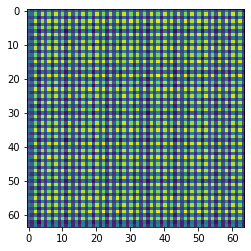

In [107]:
plt.imshow(F.sigmoid(sampled_ims_pre[0,:,:]).squeeze().detach().numpy())

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 1/50 -- Train loss: 80.44981384277344
Epoch 2/50 -- Train loss: 77.05050659179688
Epoch 3/50 -- Train loss: 75.21749877929688
Epoch 4/50 -- Train loss: 74.42823028564453
Epoch 5/50 -- Train loss: 72.97116088867188
Epoch 6/50 -- Train loss: 72.01223754882812
Epoch 7/50 -- Train loss: 70.90728759765625
Epoch 8/50 -- Train loss: 69.9815444946289
Epoch 9/50 -- Train loss: 69.18295288085938
Epoch 10/50 -- Train loss: 68.69573211669922
Epoch 11/50 -- Train loss: 67.69110870361328
Epoch 12/50 -- Train loss: 66.66361999511719
Epoch 13/50 -- Train loss: 65.78742980957031
Epoch 14/50 -- Train loss: 65.03234100341797
Epoch 15/50 -- Train loss: 64.48719787597656
Epoch 16/50 -- Train loss: 64.84906005859375
Epoch 17/50 -- Train loss: 64.23796844482422
Epoch 18/50 -- Train loss: 63.705101013183594
Epoch 19/50 -- Train loss: 63.404075622558594
Epoch 20/50 -- Train loss: 62.02071762084961
Epoch 21/50 -- Train loss: 61.193668365478516
Epoch 22/50 -- Train loss: 60.883888244628906
Epoch 23/50 -- T

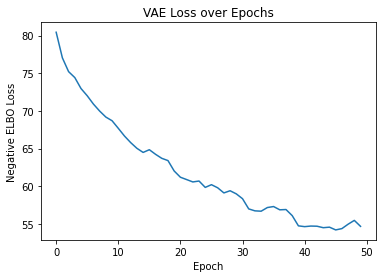

In [151]:
config["batch"] = 100
config["epoch"] = 50
config["lr"] = 1e-3
vae_train_dsprites(vae_dsprites, config, train_imgs=imgs[:30000])

In [152]:
vae_dsprites.to('cpu')
sampled_ims_post = vae_dsprites.sample_ims_from_prior(num_ims=5, train=True)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


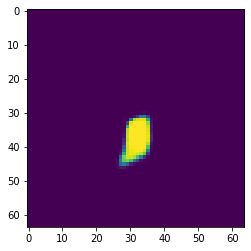

In [156]:
plt.imshow(F.sigmoid(sampled_ims_post[4,:,:]).squeeze().detach().numpy())

In [169]:
samples_like = vae_dsprites.sample_ims_like(torch.tensor(imgs[3,:,:]).float().view(1,1,64,64), num_ims=5, train=True)

In [170]:
samples_like = F.sigmoid(samples_like).squeeze().detach().numpy()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [171]:
torch.save(vae_dsprites.state_dict(), "/content/VAE_dsprites_weights")

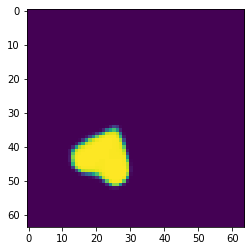

In [173]:
plt.imshow(samples_like[3,:,:])

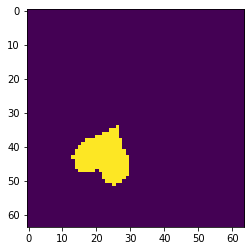

In [174]:
plt.imshow(torch.tensor(imgs[3,:,:]).float().detach().numpy())

In [67]:
datap = imgs[0,:,:] 

In [69]:
np.max(datap)

1